In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This is a notebook that executes 10-fold Cross-Validation of the MLP model. It uses all the features (T5 protein embeddings, IPR domain embeddings), as well as variable hidden layer sizes for the different aspects.

In order to execute the code, parameters PATH and ASPECT must be suitably configured, such that ASPECT should specify the aspect to be tested in the run. In spite of that, possible values for this parameter are: cellular_component' or 'biological_process' or 'molecular_function'.

In [ ]:
# config

PATH = '/content/drive/MyDrive/UniPD/BD/Biological Data Project/biological_data_pfp/'  # configure this parameter with the path to the folder containing train and test data
ASPECT = 'cellular_component'  # configure this parameter in order to execute the code for the respective aspect
                               # 'cellular_component' or 'biological_process' or 'molecular_function'

ASPECTS_HIDDEN_SIZE = {'biological_process' : 1256, 'cellular_component' : 512, "molecular_function" : 850}

In [ ]:
import pandas as pd

train_set_df = pd.read_csv(PATH + 'train/train_set.tsv', sep='\t')
train_set_df

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226
...,...,...,...
4277042,P28271,biological_process,GO:0010608
4277043,P28271,biological_process,GO:0080090
4277044,P28271,biological_process,GO:0006417
4277045,P28271,biological_process,GO:0051246


# Libraries imports

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Required for progressbar widget
import progressbar

# Load the T5 embeddings

In [ ]:
import numpy as np

# Load embeddings from the numpy file
npy_file_path_embeddings = PATH + 'train/train_embeddings.npy'
X_loaded = np.load(npy_file_path_embeddings)

# Load IDs from the numpy file
npy_file_path_ids = PATH + 'train/train_ids.npy'
ids_loaded = np.load(npy_file_path_ids)

In [ ]:
# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = X_loaded.shape[1]
t5_df = pd.DataFrame(X_loaded, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
t5_df.set_index(pd.Index(ids_loaded), inplace=True)

print(t5_df.shape)

(123969, 1024)


In [ ]:
del X_loaded

# Load domain embeddings

In [ ]:
import numpy as np

domain_embeddings = np.load(PATH + "train/domain_embeddings_pca.npy")

In [ ]:
npy_file_path_ids_pca = PATH + 'train/domain_embeddings_pca_ids.npy'
domain_embeddings_ids = np.load(npy_file_path_ids_pca, allow_pickle=True)

In [ ]:
# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = domain_embeddings.shape[1]
domains_df = pd.DataFrame(domain_embeddings, columns = ["Column_" + str(i+1024) for i in range(1, column_num+1)])
domains_df.set_index(pd.Index(domain_embeddings_ids), inplace=True)

print(domains_df.shape)

(117447, 1024)


In [ ]:
del domain_embeddings

# Combine the T5 and domain embeddings

In [ ]:
complete_df = pd.merge(t5_df, domains_df, left_index=True, right_index=True, how='inner')

In [ ]:
del t5_df, domains_df

# Split the complete df with the features of train and test dataframes

In [ ]:
# Assuming "Protein_ID" is the column with protein IDs in train_set_df
train_df = complete_df[complete_df.index.isin(train_set_df['Protein_ID'])]



In [ ]:
train_df.shape

(117447, 2048)

In [ ]:
complete_df.shape

(117447, 2048)

# Extract only the data for Cellular Component

In [ ]:
import pandas as pd

def split_dataframe_by_column(df, column_name):
    # Group the DataFrame by the specified column
    grouped = df.groupby(column_name)

    # Create a dictionary to store the resulting DataFrames
    result_dict = {}

    # Iterate through the groups and store each DataFrame in the dictionary
    for group, group_df in grouped:
        result_dict[group] = group_df

    return result_dict

train_set_splitted = split_dataframe_by_column(train_set_df, 'aspect')


In [ ]:
train_set_aspect = train_set_splitted[ASPECT]
train_set_aspect

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226
...,...,...,...
4277036,P28271,cellular_component,GO:0043226
4277037,P28271,cellular_component,GO:0005739
4277038,P28271,cellular_component,GO:0043231
4277039,P28271,cellular_component,GO:0043227


# Plot the distribution of GO Terms in train set

<ipython-input-19-1eb6cac6a946>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)


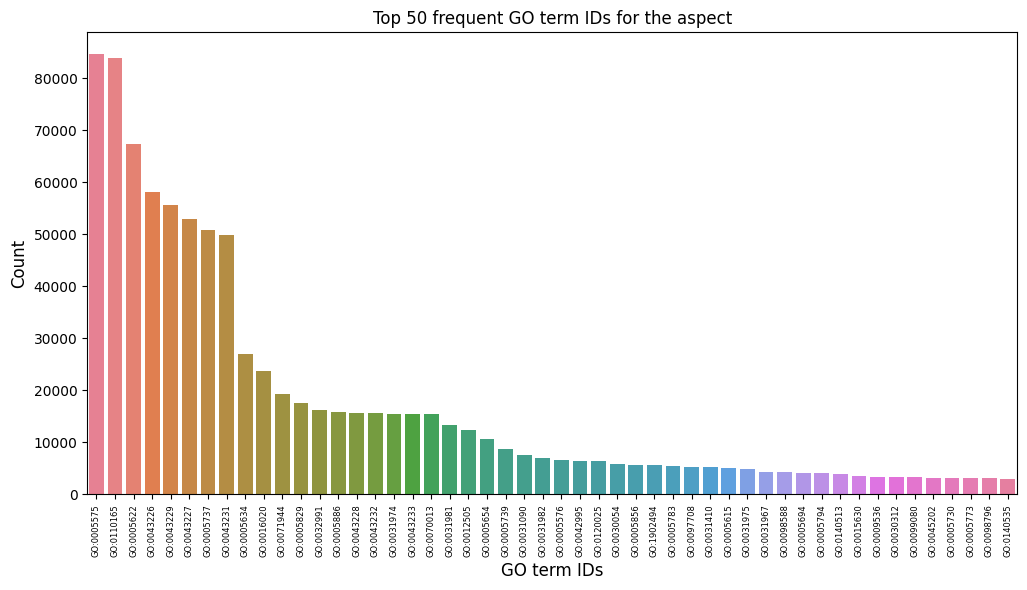

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample data
plot_df = train_set_aspect['GO_term'].value_counts().iloc[:50]

# Define a color palette (you can customize this list of colors)
colors = sns.color_palette("husl", len(plot_df))

# Create the plot
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)

# Customize the plot
axis.set_xticks(np.arange(len(plot_df.index)))
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
axis.set_title('Top 50 frequent GO term IDs for the aspect')
bp.set_xlabel("GO term IDs", fontsize=12)
bp.set_ylabel("Count", fontsize=12)

plt.show()

In [ ]:
# Set the limit for label
num_of_labels = len(train_set_aspect['GO_term'].value_counts())

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_set_aspect['GO_term'].value_counts().index[:num_of_labels].tolist()

In [ ]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_set_aspect.loc[train_set_aspect['GO_term'].isin(labels)]

# One-hot encodding of the labels for train

In [ ]:
ids_to_load_train = np.array(train_df.index)

In [ ]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = ids_to_load_train.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(ids_to_load_train)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['GO_term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['Protein_ID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df_train = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df_train.shape)

[========================================================================] 100%


(117447, 678)


In [ ]:
labels_df_train.index = ids_to_load_train

In [ ]:
import pandas as pd

# Assuming labels_df is your DataFrame with 0.0 or 1.0 values
# Count rows with at least one value of 1.0
rows_with_at_least_one_1 = (labels_df_train == 1.0).any(axis=1).sum()

# Count rows with all values set to 0.0
rows_with_all_zeros = (labels_df_train == 0.0).all(axis=1).sum()

print(f"Rows with at least one value of 1.0: {rows_with_at_least_one_1}")
print(f"Rows with all values set to 0.0: {rows_with_all_zeros}")

Rows with at least one value of 1.0: 79766
Rows with all values set to 0.0: 37681


# Order the features df and the labels df according to their index (Protein_ID)

In [ ]:
# Reindex both DataFrames based on the sorted order of the IDs
sorted_ids = sorted(train_df.index)
train_df = train_df.reindex(sorted_ids)
labels_df_train = labels_df_train.reindex(sorted_ids)

In [ ]:
del sorted_ids

# 10-fold Cross-Validation of the model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold

# Assuming train_df, labels_df are defined
# Also assuming num_of_labels is defined

# Define the number of folds
k_folds = 10

# Create KFold instance
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracy_per_fold = []
auc_per_fold = []
f1_score_per_fold = []

class RegularizedLinearModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.2):
        super(RegularizedLinearModel, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden_dim, input_dim=input_dim)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.activation1 = tf.keras.layers.ReLU()
        self.linear2 = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        return x


# Loop through each fold
for fold, (train_indices, val_indices) in enumerate(kfold.split(train_df)):
    print("="*25)
    print(f"FOLD {fold + 1}")

    # Split data into train and validation sets for this fold
    train_data, val_data = train_df.iloc[train_indices], train_df.iloc[val_indices]
    train_labels, val_labels = labels_df_train.iloc[train_indices], labels_df_train.iloc[val_indices]

    input_dim = train_df.shape[1]
    hidden_dim = ASPECTS_HIDDEN_SIZE[ASPECT]
    num_classes = num_of_labels

    # Create and compile the model with dropout and early stopping
    model = RegularizedLinearModel(input_dim, hidden_dim, num_classes, dropout_rate=0.2)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Adjust the learning rate
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.AUC(multi_label=True),
            tf.keras.metrics.F1Score(threshold=0.2),
        ],
    )

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Adjust this based on your preference
        restore_best_weights=True
    )

    # Assuming you have val_data and val_labels for validation data
    validation_data = (val_data, val_labels)

    # Train the model on this fold
    history = model.fit(
        train_data, train_labels,
        batch_size=500,
        epochs=20,
        validation_data=validation_data,
        callbacks=[early_stopping]
    )

    # Evaluate and store metrics for this fold
    _, accuracy, auc, f1_score = model.evaluate(val_data, val_labels)
    accuracy_per_fold.append(accuracy)

    # auc = history.history['val_auc'][-1]  # Assuming 'val_auc' is recorded during training
    auc_per_fold.append(auc)

    # f1_score = history.history['val_f1_score'][-1]  # Assuming 'val_f1_score' is recorded during training
    f1_score_per_fold.append(f1_score)

# Print average metrics across all folds
print("="*25)
print("Average Metrics Across Folds:")
print(f"Average Accuracy: {np.mean(accuracy_per_fold)}")
print(f"Average AUC: {np.mean(auc_per_fold)}")
print(f"Average F1 Score: {np.mean(f1_score_per_fold)}")
